In [47]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## **Load YOLO And Resnet Model Fine Tuned On MIT Indoor Dataset**

In [62]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import torch.nn.functional as F
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
!pip install ultralytics -q
!pip install pyyaml -q

classes = ['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor', 'deli', 'dentaloffice', 'dining_room', 'elevator', 'fastfood_restaurant', 'florist', 'gameroom', 'garage', 'greenhouse', 'grocerystore', 'gym', 'hairsalon', 'hospitalroom', 'inside_bus', 'inside_subway', 'jewelleryshop', 'kindergarden', 'kitchen', 'laboratorywet', 'laundromat', 'library', 'livingroom', 'lobby', 'locker_room', 'mall', 'meeting_room', 'movietheater', 'museum', 'nursery', 'office', 'operating_room', 'pantry', 'poolinside', 'prisoncell', 'restaurant', 'restaurant_kitchen', 'shoeshop', 'stairscase', 'studiomusic', 'subway', 'toystore', 'trainstation', 'tv_studio', 'videostore', 'waitingroom', 'warehouse', 'winecellar']
print(classes)
len(classes)
transformations = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.ToTensor()
    ])
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
YOLO = torch.hub.load("ultralytics/yolov5", 'custom',force_reload=True, path="/content/gdrive/MyDrive/ANN/yolov5weights/best.pt")
model = ResNet()
save_path = "/content/gdrive/MyDrive/ANN/resnetmodel/final.pth"
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.eval()           

['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor', 'deli', 'dentaloffice', 'dining_room', 'elevator', 'fastfood_restaurant', 'florist', 'gameroom', 'garage', 'greenhouse', 'grocerystore', 'gym', 'hairsalon', 'hospitalroom', 'inside_bus', 'inside_subway', 'jewelleryshop', 'kindergarden', 'kitchen', 'laboratorywet', 'laundromat', 'library', 'livingroom', 'lobby', 'locker_room', 'mall', 'meeting_room', 'movietheater', 'museum', 'nursery', 'office', 'operating_room', 'pantry', 'poolinside', 'prisoncell', 'restaurant', 'restaurant_kitchen', 'shoeshop', 'stairscase', 'studiomusic', 'subway', 'toystore', 'trainstation', 'tv_studio', 'videostore', 'waitingroom', 'warehouse', 'winecellar']


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-5-21 Python-3.10.11 torch-2.0.1+cu118 CPU

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
Adding AutoShape... 


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

## **YOLO to detect and Crop Doors**

In [63]:
resul=YOLO('/content/10 (5).png')
red=resul.crop(save=True,save_dir="/content/test")

Saved 1 image to /content/test4
Saved results to /content/test4



## **Passed That Croped Image through resnet to Classify Scene inside door**

Class: bathroom, Probability: 0.03904236853122711
Class: lobby, Probability: 0.018622683361172676
Class: bedroom, Probability: 0.017803987488150597
Class: kitchen, Probability: 0.01770627312362194
Class: livingroom, Probability: 0.015256176702678204


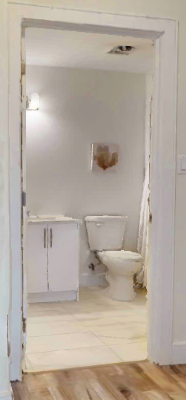

In [64]:
img_name = "/content/test4/crops/2/10 (5).jpg"
image = Image.open(img_name).convert('RGB')
example_image = transformations(image)
example_image = example_image.unsqueeze(0)
output = model(example_image)
probs = torch.nn.functional.softmax(output, dim=1)
top5_probs, top5_indices = torch.topk(probs, k=5, dim=1)
top5_probs = top5_probs.detach().numpy().squeeze()
top5_indices = top5_indices.detach().numpy().squeeze()
# Print the predicted class and probability
for prob, index in zip(top5_probs, top5_indices):
    print(f"Class: {classes[index]}, Probability: {prob}")
    
image = cv2.imread(img_name)
max_width = 600
max_height = 400

# Resize the image if it exceeds the maximum size
height, width, _ = image.shape
if width > max_width or height > max_height:
    scale = min(max_width / width, max_height / height)
    image = cv2.resize(image, None, fx=scale, fy=scale)

# Display the image using cv2.imshow()
cv2_imshow(image)


## **Resnet18 Scene Classification In Habitat** 

Class: lobby, Probability: 0.038662537932395935
Class: corridor, Probability: 0.033930499106645584
Class: bathroom, Probability: 0.015353222377598286
Class: stairscase, Probability: 0.014623407274484634
Class: dining_room, Probability: 0.014617716893553734


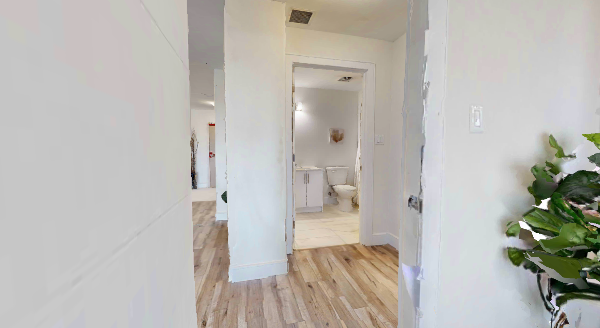

In [65]:
img_name = "/content/10 (5).png"
image = Image.open(img_name).convert('RGB')
example_image = transformations(image)
example_image = example_image.unsqueeze(0)
output = model(example_image)
probs = torch.nn.functional.softmax(output, dim=1)
top5_probs, top5_indices = torch.topk(probs, k=5, dim=1)
top5_probs = top5_probs.detach().numpy().squeeze()
top5_indices = top5_indices.detach().numpy().squeeze()
# Print the predicted class and probability
for prob, index in zip(top5_probs, top5_indices):
    print(f"Class: {classes[index]}, Probability: {prob}")
    
image = cv2.imread(img_name)
max_width = 600
max_height = 400

# Resize the image if it exceeds the maximum size
height, width, _ = image.shape
if width > max_width or height > max_height:
    scale = min(max_width / width, max_height / height)
    image = cv2.resize(image, None, fx=scale, fy=scale)

# Display the image using cv2.imshow()
cv2_imshow(image)